# Decision Making Under Uncertainty - Assignment 2

Group 2:
- Martijn Ketelaars (ANR: 120975)
- Robbie Reyerse (ANR: 109997)
- Rosalien Timmerhuis (ANR: 520618)
- Mike Weltevrede (ANR: 756479)

## Exercise a.
Derive the product-form solution for the stationary distribution of this Jackson network and determine the stability conditions (consult Lecture on 30 October).

## Exercise b.
Write for this extended system a discrete-event simulation. In order to do this, you might need object-oriented programming.

In [1]:
from scipy import stats
from collections import deque
import heapq
import numpy as np
import matplotlib.pyplot as plt

verbose = True

In [2]:
class Customer :

    def __init__(self, arrivalTime, priority):
        self.arrivalTime = arrivalTime
        self.serviceTime = 0
        self.systemArrivalTime = arrivalTime
        self.priority = priority
        
        # location: holding, needy, content, out, queue_needy
        self.location = 'holding'
        
    def moveTo(self, location, time, newServiceTime):
        
        assert location.lower() in {'holding', 'needy', 'content', 'out', 'queue_needy'},\
            "Not a proper location. Location should be holding, needy, content, out, or queue_needy"
        
        self.location = location.lower()
        self.arrivalTime = time
        self.serviceTime = newServiceTime
        
    def leaveSystem(self):
        self.location = 'out'
        self.serviceTime = -1
        

In [3]:
class Event:

    ARRIVAL = 'ARRIVAL'
    DEPARTURE = 'DEPARTURE'
    
    def __init__(self, typ, time, cust): 
        self.type = typ
        self.time = time
        self.customer = cust
        
    def __lt__(self, other):
        return self.time < other.time
        
    def __str__(self):
        s = ('Arrival', 'Departure')
        return self.type + " of customer " + str(self.customer) + ' at t = ' + str(self.time)


In [4]:
class FES :
    
    def __init__(self):
        self.events = []
        
    def add(self, event):
        heapq.heappush(self.events, event)
        
    def next(self):
        return heapq.heappop(self.events)
    
    def isEmpty(self):
        return len(self.events) == 0
        
    def __str__(self):
        # Note that if you print self.events, it would not appear to be sorted
        # (although they are sorted internally).
        # For this reason we use the function 'sorted'
        s = ''
        sortedEvents = sorted(self.events)
        for e in sortedEvents :
            s += str(e) + '\n'
        return s


In [5]:
class NeedyServer:
    
    def __init__(self, servDist, nrServers=2):
        self.servDist = servDist
        self.nrServers = nrServers
        self.number_of_customers = 0 # Number of customers at this server, not including queue
        
    def __len__(self):
        return self.number_of_customers
        
class ContentServer:
    
    def __init__(self, servDist):
        self.servDist = servDist
        self.number_of_customers = 0
    
    def __len__(self):
        return self.number_of_customers
    

In [6]:
class SimulationResults:
    
    def __init__(self):
        self.results = {
            'blocking_probability': {'high': 0,
                                     'low': 0,
                                     'total': 0},
            'waiting_probability_needy': {'high_priority': 0,
                                          'low_priority': 0},
            'mean_time_in_system': {'high_priority': 0,
                                    'low_priority': 0},
            'mean_waiting_time_in_system': {'high_priority': 0,
                                            'low_priority': 0},
            'mean_waiting_time_to_enter_system': {'high_priority': 0,
                                                  'low_priority': 0},
            'mean_queue_length': {'holding_high_priority': 0,
                                  'holding_low_priority': 0,
                                  'needy': 0},
            'utilisation_needy': 0
        }
        self.results = {}
        
        self.number_of_arrivals = {'high': 0, 'low': 0}
        self.number_of_arrivals_waiting = {'high': 0, 'low': 0}
        
        self.total_needy_queue_length = 0
        self.total_holding_queue_length = 0
        
    def register_arrival(self, priority, waiting=False):
        self.number_of_arrivals[priority] += 1

        if waiting:
            self.number_of_arrivals_waiting[priority] += 1
    
    def calculate_blocking_probability(self):
        # number of arrivals that have to wait in holding / total number of arrivals
        
        self.results['blocking_probability'] = {priority : self.number_of_arrivals_waiting[priority] / self.number_of_arrivals[priority]
                                               for priority in ('high','low')}
        self.results['blocking_probability']['total'] = sum(self.number_of_arrivals_waiting.values()) / sum(self.number_of_arrivals.values())
        
        
    def update_total_queue_length(self, length, queue_name):
        
        assert queue_name in {'needy', 'holding'}, "queue_name should be 'needy' or 'holding'"
        
        if queue_name == 'needy':
            self.total_needy_queue_length += length
        else:
            self.total_holding_queue_length += length
        

In [7]:
class Network:
    
    def __init__(self, lambda_L, lambda_H, servDist_needy, nrServers, servDist_content, N, p):
        self.arrDist = stats.expon(scale=1/(lambda_L+lambda_H))
        self.high_priority_probability = lambda_H/(lambda_L+lambda_H) # probability for high
        self.N = N
        self.p = p
        
        # Create servers
        self.NeedyServer = NeedyServer(servDist_needy, nrServers)
        self.ContentServer = ContentServer(servDist_content)
        self.simresults = SimulationResults()
        
    def simulate(self, T):
        
        t = 0 # initialise time
        total_needy_queue=0
        
        fes = FES()                  
        queue_holding_high = deque() # the holding queue for high priority
        queue_holding_low = deque()  # the holding queue for low priority
        queue_needy = deque()        # the queue for needy server
        
        # Generate arrival of the first customer
        u = stats.uniform().rvs()
        
        if u < self.high_priority_probability:
            c0 = Customer(self.arrDist.rvs(), priority='high')
        else:
            c0 = Customer(self.arrDist.rvs(), priority='low')
            
        firstEvent = Event(Event.ARRIVAL, c0.arrivalTime, c0)
        fes.add(firstEvent) # schedule first arrival event
        
        # if number people < N: go to needy queue
        while t < T:
            
            e = fes.next()                      # jump to next event
            t = e.time                          # update the time
            c1 = e.customer                     # customer associated with this event
            
            number_in_system = len(queue_needy) + len(self.NeedyServer) + len(self.ContentServer)
            
            # Update total number of people that had to wait in the needy queue
            self.simresults.update_total_queue_length(length=len(queue_needy), queue_name='needy')
            
            if e.type == 'ARRIVAL':
                if c1.location == 'holding':
                    
                    # Someone arrive
                    if number_in_system <= self.N:
                        
                        # Admit this customer
                        if len(self.NeedyServer) < self.NeedyServer.nrServers:
                            # Admit this customer
                            serviceTime = self.NeedyServer.servDist.rvs()
                            c1.moveTo('needy', t, serviceTime)
                            
                            # Update number of customers at needy server
                            self.NeedyServer.number_of_customers += 1
                            
                            dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                            fes.add(dep)

                        else:
                            # Queue in needy, independent of priority
                            queue_needy.append(c1)
                            c1.moveTo('queue_needy', t, _)

                        self.simresults.register_arrival(priority=c1.priority)
                            
                    else:
                        # else: add to holding queue
                        if c1.priority == 'high':
                            queue_holding_high.append(c1)
                        else:
                            queue_holding_low.append(c1)
                            
                        self.simresults.register_arrival(priority=c1.priority, waiting=True)

                    # Schedule new arrival
                    u = stats.uniform().rvs()

                    if u < self.high_priority_probability:
                        c2 = Customer(self.arrDist.rvs(), priority='high')
                    else:
                        c2 = Customer(self.arrDist.rvs(), priority='low')

                    arrival = Event(Event.ARRIVAL, t + c2.arrivalTime, c2)
                    fes.add(arrival)
                else:
                    raise Exception("ERROR: Arrival from", c1.location)
                    
                
            elif e.type == 'DEPARTURE':
                # Then it's a departure
                
                # Check if departed from needy or from content
                if c1.location == 'content':
                    
                    # Update number of customers at needy server
                    self.ContentServer.number_of_customers -= 1
                    
                    if len(self.NeedyServer) < self.NeedyServer.nrServers:
                        serviceTime = self.NeedyServer.servDist.rvs()
                        c1.moveTo('needy', t, serviceTime)
                        
                        # Update number of customers at needy server
                        self.NeedyServer.number_of_customers += 1
                        
                        dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                        fes.add(dep)
                    else:
                        queue_needy.append(c1)
                        c1.moveTo('queue_needy', t, _)
                        
                elif c1.location == 'needy':
                    
                    # Update number of customers at needy server
                    self.NeedyServer.number_of_customers -= 1
                    
                    # Admit person from needy queue, if nonempty
                    if len(queue_needy) > 0:
                        c2 = queue_needy.popleft()
                        
                        serviceTime = self.NeedyServer.servDist.rvs()
                        c2.moveTo('needy', t, serviceTime)

                        # Update number of customers at needy server
                        self.NeedyServer.number_of_customers += 1

                        dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                        fes.add(dep)
                    
                    # Check if leaves or goes to content
                    u = stats.uniform().rvs()

                    if u < self.p:
                        # Go to content
                        serviceTime = self.ContentServer.servDist.rvs()
                        c1.moveTo('content', t, serviceTime)
                        
                        # Update number of customers at needy server
                        self.ContentServer.number_of_customers += 1
                        
                        dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                        fes.add(dep)
                        
                    else:
                        # Leave system
                        c1.leaveSystem() # Set c1.location to out and c1.serviceTime to -1
                        
                        # Admit someone from holding queue
                        if len(queue_holding_high) > 0:
                            c2 = queue_holding_high.popleft()
                            
                            # Note that we only enter here if a person is admitted from the holding queue
                            if len(self.NeedyServer) < self.NeedyServer.nrServers:
                                serviceTime = self.NeedyServer.servDist.rvs()
                                c2.moveTo('needy', t, serviceTime)

                                # Update number of customers at needy server
                                self.NeedyServer.number_of_customers += 1

                                dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                                fes.add(dep)
                            else:
                                queue_needy.append(c2)
                                c2.moveTo('queue_needy', t, _)
                            
                        elif len(queue_holding_low) > 0:
                            c2 = queue_holding_low.popleft()
                            
                            # Note that we only enter here if a person is admitted from the holding queue
                            if len(self.NeedyServer) < self.NeedyServer.nrServers:
                                serviceTime = self.NeedyServer.servDist.rvs()
                                c2.moveTo('needy', t, serviceTime)

                                # Update number of customers at needy server
                                self.NeedyServer.number_of_customers += 1

                                dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                                fes.add(dep)
                            else:
                                queue_needy.append(c2)
                                c2.moveTo('queue_needy', t, _)
                        else:
                            pass
                        
                else:
                    raise Exception("ERROR: Departure from", c1.location)
        return "Simulation finished"

In [8]:
np.random.seed(1)

mu = 1
delta = 1

servDist_needy = stats.expon(scale=float(1/mu))
servDist_content = stats.expon(scale=1/float(1/delta))

sim = Network(lambda_L=6, lambda_H=4, servDist_needy=servDist_needy, nrServers=2,
              servDist_content=servDist_content, N=25, p=0.4)

q_n = sim.simulate(T=1000)
print(q_n)

Simulation finished


In [9]:
sim.simresults.calculate_blocking_probability()
print(sim.simresults.results)

q_n = sim.simresults.total_needy_queue_length
print("q_n:", q_n)

{'blocking_probability': {'high': 0.9969811320754717, 'low': 0.9973408675419644, 'total': 0.9971977582065652}}
q_n: 297008


## Exercise c.
Use your discrete-event simulation to present performance measures (perhaps probability of blocking for the different customer priority classes, probability of waiting, mean queue length, mean waiting time,...) for the extended system for different values of $\lambda_L$, $\lambda_H$, and $\delta$, and different values of $N$. Elaborate on your findings by creating a comprehensive management report including several sensitivity analyses.

In [10]:
#changing lambda L (and thus fix lambda H)
np.random.seed(1)
runs = 10
T = 100

# Initialise arguments
lambda_L = 1
lambda_H = 4
nrServers = 2
N = 25
p = 0.4

mu = 1
delta = 1

servDist_needy = stats.expon(scale=float(1/mu))
servDist_content = stats.expon(scale=1/float(1/delta))

# Specify which values for lambda_L to test
lambda_L_array = np.linspace(1, 12, runs)

probabilities_high = np.zeros(runs)
probabilities_low = np.zeros(runs)

for i in range(runs):
    lambda_L = lambda_L_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    sim.simresults.calculate_blocking_probability()
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("Probability for lambda_L equal to", lambda_L)
        print("Blocking probability:", sim.simresults.results['blocking_probability'])
        print("")
    
    probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
    probabilities_low[i] = sim.simresults.results['blocking_probability']['low']

Probability for lambda_L equal to 1.0
Blocking probability: {'high': 0.9355670103092784, 'low': 0.900990099009901, 'total': 0.9284253578732107}

Probability for lambda_L equal to 2.2222222222222223
Blocking probability: {'high': 0.9527363184079602, 'low': 0.9372384937238494, 'total': 0.9469578783151326}

Probability for lambda_L equal to 3.4444444444444446
Blocking probability: {'high': 0.9658792650918635, 'low': 0.9449275362318841, 'total': 0.9559228650137741}

Probability for lambda_L equal to 4.666666666666667
Blocking probability: {'high': 0.9609375, 'low': 0.968944099378882, 'total': 0.9653979238754326}

Probability for lambda_L equal to 5.888888888888889
Blocking probability: {'high': 0.9623115577889447, 'low': 0.9778156996587031, 'total': 0.9715447154471545}

Probability for lambda_L equal to 7.111111111111112
Blocking probability: {'high': 0.9785522788203753, 'low': 0.9689608636977058, 'total': 0.9721723518850988}

Probability for lambda_L equal to 8.333333333333334
Blocking pr

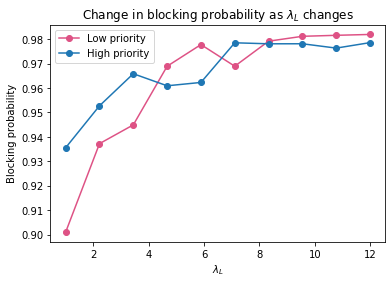

In [11]:
plt.plot(lambda_L_array, probabilities_low, marker='o', color='#de5285', label="Low priority")
plt.plot(lambda_L_array, probabilities_high, marker='o', label="High priority")
plt.xlabel('$\lambda_L$')
plt.ylabel('Blocking probability')
plt.title('Change in blocking probability as $\lambda_L$ changes')
plt.legend(loc='upper left')
plt.show()

In [12]:
#changing lambda H (and thus fix lambda_L)
np.random.seed(1)

# Reset lambda_H and lambda_L
lambda_L = 6
lambda_H = 1

# Specify which values for lambda_H to test
lambda_H_array = np.linspace(1, 12, runs)

probabilities_high = np.zeros(runs)
probabilities_low = np.zeros(runs)

for i in range(runs):
    lambda_H = lambda_H_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    sim.simresults.calculate_blocking_probability()
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("Probability for lambda_H equal to", lambda_H)
        print("Blocking probability:", sim.simresults.results['blocking_probability'])
        print("")
    
    probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
    probabilities_low[i] = sim.simresults.results['blocking_probability']['low']

Probability for lambda_H equal to 1.0
Blocking probability: {'high': 0.935064935064935, 'low': 0.9667194928684627, 'total': 0.963276836158192}

Probability for lambda_H equal to 2.2222222222222223
Blocking probability: {'high': 0.9487179487179487, 'low': 0.9716666666666667, 'total': 0.9652278177458034}

Probability for lambda_H equal to 3.4444444444444446
Blocking probability: {'high': 0.9608433734939759, 'low': 0.9769503546099291, 'total': 0.9709821428571429}

Probability for lambda_H equal to 4.666666666666667
Blocking probability: {'high': 0.9735772357723578, 'low': 0.9772357723577236, 'total': 0.975609756097561}

Probability for lambda_H equal to 5.888888888888889
Blocking probability: {'high': 0.9706390328151986, 'low': 0.9776632302405498, 'total': 0.9741602067183462}

Probability for lambda_H equal to 7.111111111111112
Blocking probability: {'high': 0.9809782608695652, 'low': 0.9756493506493507, 'total': 0.9785502958579881}

Probability for lambda_H equal to 8.333333333333334
Blo

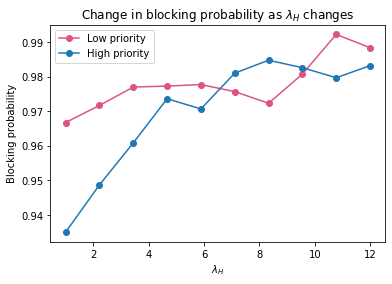

In [13]:
plt.plot(lambda_H_array, probabilities_low, marker='o', color='#de5285', label="Low priority")
plt.plot(lambda_H_array, probabilities_high, marker='o', label="High priority")
plt.xlabel('$\lambda_H$')
plt.ylabel('Blocking probability')
plt.title('Change in blocking probability as $\lambda_H$ changes')
plt.legend(loc='upper left')
plt.show()

In [14]:
# Changing p (comparing the needy queue length)
np.random.seed(1)

# Reset lambda_H and lambda_L and initialise p
lambda_L = 6
lambda_H = 4

# Specify which values for p to test
p_array = np.linspace(0, 1, runs)

mean_queue_length = np.zeros(runs)

for i in range(runs):
    p = p_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    
    q_n = sim.simresults.total_needy_queue_length 
    q_n_mean = q_n / (T *13)
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("Probability of not leaving system equal to", p)
        print("Mean queue length: ", q_n_mean)
        print("")
    
    mean_queue_length[i] = q_n_mean

Probability of not leaving system equal to 0.0
Mean queue length:  22.09076923076923

Probability of not leaving system equal to 0.1111111111111111
Mean queue length:  22.563076923076924

Probability of not leaving system equal to 0.2222222222222222
Mean queue length:  22.516153846153845

Probability of not leaving system equal to 0.3333333333333333
Mean queue length:  22.493076923076924

Probability of not leaving system equal to 0.4444444444444444
Mean queue length:  22.076153846153847

Probability of not leaving system equal to 0.5555555555555556
Mean queue length:  22.942307692307693

Probability of not leaving system equal to 0.6666666666666666
Mean queue length:  23.34769230769231

Probability of not leaving system equal to 0.7777777777777777
Mean queue length:  22.78846153846154

Probability of not leaving system equal to 0.8888888888888888
Mean queue length:  22.25769230769231

Probability of not leaving system equal to 1.0
Mean queue length:  22.946153846153845



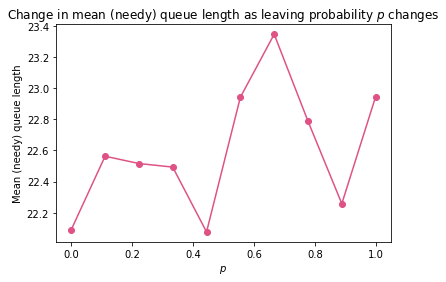

In [15]:
plt.plot(p_array, mean_queue_length, marker='o', color='#de5285')
plt.xlabel('$p$')
plt.ylabel('Mean (needy) queue length')
plt.title('Change in mean (needy) queue length as leaving probability $p$ changes')
plt.show()

## Exercise d.
Investigate the difference in performance between the original system ($N = 1$) and the extended system (finite $N$). For instance, how fast does the behavior of the extended system mimic the original system behavior as $N$ increases?